In [1]:
import numpy as np 
import tensorflow as tf 
import pdb 
import matplotlib.pyplot as plt

%matplotlib inline

def sharp_sig(X):
    den = 1 + tf.exp(-X)
    val = 2*den**(-1) - 1
    return val 

In [40]:
def basic_MLP(X,sizes,is_training,bits=8,dropout=False): 
    layers = {}
    layers[0] = tf.layers.dense(X, sizes[0],
                                activation = tf.nn.relu,
                                use_bias=False,
                                )
    if dropout:
        dropout_key = str(0)+'d' 
        layers[dropout_key] = tf.layers.dropout(layers[0],
                                                rate=0.25,
                                                training=is_training)
    for j,  size in enumerate(sizes[1:]): 
        i = j+1
        if dropout: 
            dropout_key_prior = str(i-1)+'d' 
            layers[i] = tf.layers.dense(layers[dropout_key_prior], size,
                                    activation = tf.nn.relu,
                                    use_bias=True,
                                    )
            dropout_key = str(i)+'d' 
            layers[dropout_key] = tf.layers.dropout(layers[dropout_key],
                                                rate=0.25,
                                                training=is_training)
        else:
            layers[i] = tf.layers.dense(layers[i-1], size,
                                    activation = tf.nn.relu,
                                    use_bias=True,
                                    )

    binary = tf.layers.dense(layers[len(sizes)-1], bits,
#                                     activation = sharp_sig,
                                   activation = tf.tanh,
                                   use_bias=True,
                                    ) 
    
    output = tf.layers.dense(binary, 1,
                            activation = None,
                            use_bias=False,
                                    ) 
    return [output, binary]


In [41]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 1])
Y = tf.placeholder(tf.float32, [None, 1])
LR = tf.placeholder(tf.float32, [None,])
is_training = tf.placeholder(tf.bool)

sizes = [512, 512, 512]
output, binary = basic_MLP(X,sizes,is_training,bits=16,dropout=False)

# binary_loss = tf.reduce_mean((binary**3 - binary)**2)
binary_loss = tf.reduce_mean(tf.abs(1 - binary**2)
                            + (1 - binary**2)**2)
trans_loss = tf.reduce_mean((output - Y)**2)

loss = trans_loss + 1.0*binary_loss

optimizer = tf.train.AdamOptimizer(1e-3) 
train_step = optimizer.minimize(loss)

In [42]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [43]:
X_train = np.arange(-1.5, 1.5, 0.01)
X_train = X_train.reshape([-1,1])
feed_dict = {X:X_train, Y:X_train, is_training:True}



B_LOSS = []
T_LOSS = []
for i in range(1000):
    _, b_loss, t_loss, bin_res = sess.run([train_step, binary_loss, trans_loss, binary], feed_dict)
    B_LOSS.append(b_loss)
    T_LOSS.append(t_loss)
    if (i+1)%100 == 0:
        print('Training step %r' % (i+1) )
        print('Binary Loss: %r; Translation Loss: %r' % (b_loss, t_loss))

Training step 100
Binary Loss: 0.068537228; Translation Loss: 0.054532539
Training step 200
Binary Loss: 0.032635741; Translation Loss: 0.025735788


KeyboardInterrupt: 

In [79]:
error = []
for i in range(X_train.shape[0]):
    Xd = X_train[i,0].reshape([1,1])
    feed_dict = {X:Xd, Y:Xd, is_training:False}
    b_loss, t_loss = sess.run([binary_loss, trans_loss], feed_dict)
    error.append(t_loss)
max_error = np.amax(error)
print('Maximum error:',max_error)

Maximum error: 0.0931197


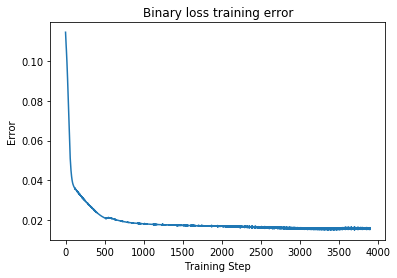

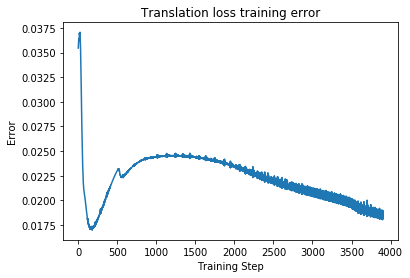

In [80]:
plt.figure()
plt.plot(B_LOSS[100:])
plt.title('Binary loss training error')
plt.xlabel('Training Step')
plt.ylabel('Error')
plt.show()

plt.figure()
plt.plot(T_LOSS[100:])
plt.title('Translation loss training error')
plt.xlabel('Training Step')
plt.ylabel('Error')
plt.show()

In [81]:
np.unique(np.round(bin_res, 2))

array([-1.        , -0.99000001, -0.98000002, -0.97000003, -0.95999998,
       -0.94999999, -0.94      , -0.93000001, -0.92000002, -0.91000003,
       -0.89999998, -0.88999999, -0.88      , -0.86000001, -0.83999997,
       -0.82999998, -0.81999999, -0.81      , -0.80000001, -0.79000002,
       -0.76999998, -0.75999999, -0.74000001, -0.70999998, -0.68000001,
       -0.66000003, -0.60000002, -0.52999997, -0.44999999, -0.36000001,
       -0.27000001, -0.17      , -0.08      , -0.07      ,  0.03      ,
        0.13      ,  0.23      ,  0.33000001,  0.41999999,  0.5       ,
        0.56999999,  0.58999997,  0.63999999,  0.64999998,  0.66000003,
        0.67000002,  0.68000001,  0.69      ,  0.69999999,  0.70999998,
        0.72000003,  0.73000002,  0.74000001,  0.75      ,  0.75999999,
        0.76999998,  0.77999997,  0.79000002,  0.80000001,  0.81      ,
        0.81999999,  0.82999998,  0.83999997,  0.85000002,  0.86000001,
        0.87      ,  0.88      ,  0.88999999,  0.89999998,  0.91